In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [3]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array


def create_extrema_dict(t_data, l_data, r_data):
    extrema_dict = {
        0: {
            'peaks_i': t_data[0],
            'peaks_a': t_data[1],
            'valleys_i': t_data[2],
            'valleys_a': t_data[3]
        },
        1: {
            'peaks_i': l_data[0],
            'peaks_a': l_data[1],
            'valleys_i': l_data[2],
            'valleys_a': l_data[3]
        },
        2: {
            'peaks_i': r_data[0],
            'peaks_a': r_data[1],
            'valleys_i': r_data[2],
            'valleys_a': r_data[3]
        }
    }
    return extrema_dict

In [4]:
from megabouts_helper import labels_cat, color, color_bouts, cmp_bouts, color_ipsi_cont

In [5]:
master_path = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data')
path_tensors = Path(master_path/ 'tensors'/'tensor_ipsi_contra_pos.h5')
path_features = Path(master_path/ 'features_bouts_new.csv')
laterality = fl.load(master_path/ 'features'/'bout_laterality.h5')
master_path, path_features

(WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data'),
 WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new.csv'))

In [6]:
save_figure_path = Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Figure_2\fig_2')

In [7]:
### tail, fin 1, fin 2, left eye, right eye

traces =  fl.load(path_tensors)
traces.shape

(11063, 3, 50)

In [8]:
tail = traces[:, 0, :]

ipsi_fin = traces[:, 1, :]
contra_fin = traces[:, 2, :]

In [9]:
#Load the Set2 colormap
cmap = plt.get_cmap('Set2')

#Get two colors from the colormap
color1 = cmap(0) # Get the first color
color2 = cmap(3) # Get the second color
color3 = cmap(7) # Get the second color

print("Color 1:", color1)
print("Color 2:", color2)

color_ipsi_cont = [color1, color2, color3]

Color 1: (0.4, 0.7607843137254902, 0.6470588235294118, 1.0)
Color 2: (0.9058823529411765, 0.5411764705882353, 0.7647058823529411, 1.0)


### read in features

In [10]:
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_proba,max_eye_rot,...,tail_freq,l_fin_freqs,r_fin_freqs,tail_max_freq,l_fin_max_freqs,r_fin_max_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,0.806645,-0.239648,...,0.121622,0.105263,0.109756,0.166667,0.166667,0.166667,0.0,27.0,0.0,28.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,1.000000,0.479035,...,0.058140,0.117647,0.119048,0.166667,0.166667,0.250000,0.0,15.0,7.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,1.000000,-1.120168,...,0.097561,0.115385,0.104167,0.166667,0.166667,0.125000,4.0,20.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,1.000000,-2.662451,...,0.114286,0.117647,0.117647,0.166667,0.166667,0.125000,19.0,35.0,0.0,35.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,1.000000,-1.192489,...,0.108108,0.116667,0.103448,0.166667,0.125000,0.125000,0.0,23.0,6.0,28.0


In [11]:
clusters = features.cluster

In [12]:
ipsi_fin_values = features.ipsi_fin.values
ipsi_fin_values

array([1., 1., 1., ..., 0., 0., 1.])

In [13]:
ipsi_mask = features['ipsi_fin'].values.astype(int)
contra_mask = np.where((ipsi_mask==0)|(ipsi_mask==1), ipsi_mask^1, ipsi_mask)


In [14]:
path_traces =  Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\tensors\tensor.h5')

In [15]:
traces_2 = fl.load(path_traces)

In [16]:
corr_ =[]
ipsi_mask = features['ipsi_fin'].values.astype(int)
contra_mask = np.where((ipsi_mask==0)|(ipsi_mask==1), ipsi_mask^1, ipsi_mask)

for i, cluster in enumerate([1, 5]):
    tail_traces = traces_2[:, 0, :][clusters==cluster]
    
    for mask, col_ in zip([ipsi_mask, contra_mask], [color_ipsi_cont[0], color_ipsi_cont[1]]):
        fin_traces = traces_2[:, 1:3, :][np.arange(traces_2.shape[0]), mask, :][clusters==cluster]
        corrcoefs = [np.corrcoef(tail_traces[i, :], fin_traces[i, :])[0,1] for i in range((clusters==cluster).sum())]
        corr_.append(corrcoefs)

In [17]:
len(corr_)
i_fwd = corr_[0]
c_fwd = corr_[1]
i_turn = corr_[2]
c_turn = corr_[3]


### Rolling corr

In [18]:
t_feature_vector_array = fl.load(master_path/ 'peaks_valleys'/  't_feature_vector_array.h5')
l_feature_vector_array = fl.load(master_path/ 'peaks_valleys'/  'l_feature_vector_array.h5')
r_feature_vector_array = fl.load(master_path/ 'peaks_valleys'/  'r_feature_vector_array.h5')

laterality = fl.load(master_path/ 'features'/'bout_laterality.h5')
#Load TBF data
tbf_output = fl.load(master_path / 'tbf_fbf' / 'tbf_output.h5')


In [19]:
max_n=9

reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array = reshape_feature_array(t_feature_vector_array)
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(l_feature_vector_array)
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(r_feature_vector_array)

Reshaped array shape: (11063, 4, 9)
Reshaped array shape: (11063, 4, 9)
Reshaped array shape: (11063, 4, 9)


In [20]:
extrema_dict = create_extrema_dict(
    (peaks_i_array, peaks_a_array, valleys_i_array, valleys_a_array),
    (l_peaks_i_array, l_peaks_a_array, l_valleys_i_array, l_valleys_a_array),
    (r_peaks_i_array, r_peaks_a_array, r_valleys_i_array, r_valleys_a_array)
)

print(extrema_dict.keys())  # Output: dict_keys([0, 1, 2])
print(extrema_dict[0].keys())  # Output: dict_keys(['peaks_i', 'peaks_a', 'valleys_i', 'valleys_a'])


dict_keys([0, 1, 2])
dict_keys(['peaks_i', 'peaks_a', 'valleys_i', 'valleys_a'])


In [21]:
dt = 0.25/traces_2.shape[2]
tps = np.arange(traces_2.shape[2])*dt

In [22]:
### COMPUTE ROLLING CORRELATION BETWEEN THE TWO FIN TRACES ###

window = 10 #Size of the rolling window
min_periods = 2 #Minimum size required for computing the correlation 

fin_corr_evol = []

for bout in range(traces_2.shape[0]):
    fin_df = pd.DataFrame(data=traces_2[bout, [1,2], :].T, columns=['fin1', 'fin2'])
    fin_corr_evol.append(fin_df['fin1'].rolling(window, min_periods=min_periods).corr(fin_df['fin2']))
    
fin_corr_evol = np.stack([series.values for series in fin_corr_evol])

### Now horizontal

In [23]:
alph=0.2
dt = 0.005
bins = np.arange(-1, 1.1, 0.1)
lw=0.5
cm = 1/2.54  # centimeters in inches
f_size = 6
tick_label_size = f_size
dpi=600

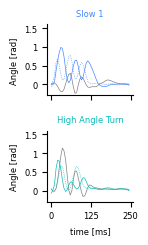

In [37]:
fig, axes = plt.subplots(2,1,figsize=(4*cm, 6.5*cm), sharex=True, sharey=True, facecolor='None') 
axes = axes.ravel()
axes[0].set_title('Slow 1', c=color[1], fontsize=f_size)
axes[1].set_title('High Angle Turn', c=color[5], fontsize=f_size)

bout=395
axes[0].plot(tail[clusters == 1][bout].T , c='gray',lw=lw)
axes[0].plot(ipsi_fin[clusters == 1][bout].T , c=color[1],lw=lw)
axes[0].plot(contra_fin[clusters == 1][bout].T , c=color[1], ls=':',lw=lw)

bout=403
axes[1].plot(tail[clusters == 5][bout].T , c='gray', label='Tail',lw=lw)
axes[1].plot(ipsi_fin[clusters == 5][bout].T , c=color[5], label='Ipsi Fin',lw=lw)
axes[1].plot(contra_fin[clusters == 5][bout].T , c=color[5], ls=':', label='Contra Fin',lw=lw)

for ax in axes:
    ax.set_ylim(-0.3, 1.6)
    ax.set_xticks(np.arange(0,51,25))
    ax.set_xticklabels(np.arange(0,251,125), fontsize=f_size)
    ax.set_yticks([0,0.5, 1, 1.5])
    ax.set_yticklabels([0,0.5, 1, 1.5], fontsize=f_size)
    ax.set_ylabel('Angle [rad]', fontsize=f_size)
axes[1].set_xlabel('time [ms]', fontsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(save_figure_path / 'exp_traces.png', dpi=dpi)
fig.savefig(save_figure_path / 'exp_traces.pdf', dpi=dpi)

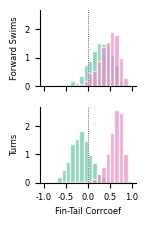

In [52]:
fig, axes = plt.subplots(2,1,figsize=(4*cm,6*cm), sharex=True, sharey=True, facecolor='None') 
axes = axes.ravel()

axes[0].hist(i_fwd, color = color_ipsi_cont[0], bins=bins,edgecolor='w', density=True, alpha=0.7)
axes[0].hist(c_fwd, color = color_ipsi_cont[1], bins=bins,edgecolor='w', density=True, alpha=0.7)
axes[1].hist(i_turn, color = color_ipsi_cont[0], bins=bins,edgecolor='w', density=True, alpha=0.7)
axes[1].hist(c_turn, color = color_ipsi_cont[1], bins=bins,edgecolor='w', density=True, alpha=0.7)

for ax_ in axes:
    ax_.axvline(0, c='k',ls=':', lw=lw)
    ax_.set_yticks(np.arange(0,3,1))
    ax_.set_xticks(np.arange(-1,1.1,0.5))
    ax_.set_yticklabels(np.round(np.arange(0,3,1),2), fontsize=f_size)
    ax_.set_xticklabels(np.round(np.arange(-1,1.1,0.5),2), fontsize=f_size)

axes[0].set_ylabel('Forward Swims', fontsize=f_size)  
axes[1].set_ylabel('Turns', fontsize=f_size) 
axes[1].set_xlabel('Fin-Tail Corrcoef', fontsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(save_figure_path / 'fin_tail_corr.png', dpi=dpi)
fig.savefig(save_figure_path / 'fin_tail_corr.pdf', dpi=dpi)

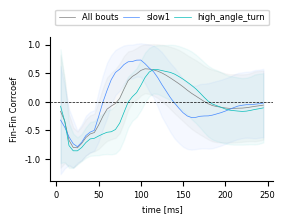

In [51]:
fig,ax = plt.subplots(figsize=(7.5*cm, 6*cm), facecolor='None')
mean = np.nanmean(fin_corr_evol, 0)
std = np.nanstd(fin_corr_evol, 0)
ax.plot(tps, mean, c='gray', label='All bouts', lw=lw)
ax.fill_between(tps, mean-std, mean+std, color='gray', alpha=.05)

for i, cluster in enumerate([1, 5]):
    mean = np.nanmean(fin_corr_evol[clusters==cluster], 0)
    std = np.nanstd(fin_corr_evol[clusters==cluster], 0)
    tps = np.arange(mean.shape[0])*dt*1000  # Multiply by 1000 to convert to ms
    ax.plot(tps, mean, c=color[cluster], label=labels_cat[cluster], lw=lw)
    ax.fill_between(tps, mean-std, mean+std, color=color[cluster], alpha=.05)

ax.axhline(0, c='black', ls='--', lw=lw)
ax.set_xlabel('time [ms]', fontsize=f_size)
ax.set_ylabel('Fin-Fin Corrcoef', fontsize=f_size)
ax.legend(bbox_to_anchor=(0.5, 1.05), loc='lower center', shadow=False, ncol=3, fontsize=f_size, columnspacing=0.5)

ax.set_yticks(np.arange(-1, 1.1, 0.5))
ax.set_yticklabels(np.arange(-1, 1.1, 0.5), fontsize=f_size)
ax.set_xticks(np.arange(0,251,50))
ax.set_xticklabels(np.arange(0,251,50),fontsize=f_size)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(save_figure_path / 'fin_fin_corr.png', dpi=dpi)
fig.savefig(save_figure_path / 'fin_fin_corr.pdf', dpi=dpi)

In [41]:
# fig = plt.figure(figsize=(16*cm, 7*cm)) # adjust the size of the figure to be wider
# gs = gridspec.GridSpec(2, 3, width_ratios=[0.5, 0.5, 1])  # last column plot is twice as wide as the first two columns

# ax1 = plt.subplot(gs[0, 0])  # first column, first row
# ax2 = plt.subplot(gs[1, 0])  # first column, second row
# ax3 = plt.subplot(gs[0, 1])  # second column, first row
# ax4 = plt.subplot(gs[1, 1])  # second column, second row
# ax5 = plt.subplot(gs[:, 2])  # third column, spans both rows


# ax1.set_title('Slow 1', c=color[1], fontsize=f_size)
# ax2.set_title('High Angle Turn', c=color[5], fontsize=f_size)

# bout=395
# ax1.plot(tail[clusters == 1][bout].T , c='gray',lw=lw)
# ax1.plot(ipsi_fin[clusters == 1][bout].T , c=color[1],lw=lw)
# ax1.plot(contra_fin[clusters == 1][bout].T , c=color[1], ls=':',lw=lw)

# bout=403
# ax2.plot(tail[clusters == 5][bout].T , c='gray', label='Tail',lw=lw)
# ax2.plot(ipsi_fin[clusters == 5][bout].T , c=color[5], label='Ipsi Fin',lw=lw)
# ax2.plot(contra_fin[clusters == 5][bout].T , c=color[5], ls=':', label='Contra Fin',lw=lw)

# ax3.hist(i_fwd, color = color_ipsi_cont[0], bins=bins,edgecolor='w', density=True, alpha=0.7)
# ax3.hist(c_fwd, color = color_ipsi_cont[1], bins=bins,edgecolor='w', density=True, alpha=0.7)
# ax4.hist(i_turn, color = color_ipsi_cont[0], bins=bins,edgecolor='w', density=True, alpha=0.7)
# ax4.hist(c_turn, color = color_ipsi_cont[1], bins=bins,edgecolor='w', density=True, alpha=0.7)

# for ax in [ax1, ax2]:
#     ax.set_ylim(-0.3, 1.6)
#     ax.set_xticks(np.arange(0,51,25))
#     ax.set_xticklabels(np.arange(0,251,125), fontsize=f_size)
#     ax.set_yticks([0,0.5, 1, 1.5])
#     ax.set_yticklabels([0,0.5, 1, 1.5], fontsize=f_size)
#     ax.set_ylabel('Angles [rad]', fontsize=f_size)

# ax2.set_xlabel('time [ms]', fontsize=f_size)

# for ax_ in [ax3, ax4]:
#     ax_.axvline(0, c='k',ls=':', lw=lw)
#     ax_.set_yticks(np.arange(0,3,1))
#     ax_.set_xticks(np.arange(-1,1.1,0.5))
#     ax_.set_yticklabels(np.round(np.arange(0,3,1),2), fontsize=f_size)
#     ax_.set_xticklabels(np.round(np.arange(-1,1.1,0.5),2), fontsize=f_size)
#     ax_.set_ylabel('Density', fontsize=f_size)
    
# ax4.set_xlabel('Fin-Tail Corrcoef', fontsize=f_size)

# mean = np.nanmean(fin_corr_evol, 0)
# std = np.nanstd(fin_corr_evol, 0)
# ax5.plot(tps, mean, c='gray', label='All bouts', lw=lw)
# ax5.fill_between(tps, mean-std, mean+std, color='gray', alpha=.05)

# for i, cluster in enumerate([1, 5]):
#     mean = np.nanmean(fin_corr_evol[clusters==cluster], 0)
#     std = np.nanstd(fin_corr_evol[clusters==cluster], 0)
#     tps = np.arange(mean.shape[0])*dt*1000  # Multiply by 1000 to convert to ms
#     ax5.plot(tps, mean, c=color[cluster], label=labels_cat[cluster], lw=lw)
#     ax5.fill_between(tps, mean-std, mean+std, color=color[cluster], alpha=.05)

# ax5.set_yticklabels(np.arange(-1, 1.1, 0.5), fontsize=f_size)
# ax5.set_xticks(np.arange(0,251,50))
# ax5.set_xticklabels(np.arange(0,251,50),fontsize=f_size-2)

# ax5.axhline(0, c='black', ls='--', lw=lw)
# ax5.set_xlabel('time [ms]', fontsize=f_size)
# ax5.set_ylabel('Fin-Fin Corrcoef', fontsize=f_size)
# ax5.legend(bbox_to_anchor=(0.5, 1.05), loc='lower center', shadow=False, ncol=3, fontsize=f_size, columnspacing=0.5)

# ax5.set_yticks(np.arange(-1, 1.1, 0.5))
# ax5.set_yticklabels(np.arange(-1, 1.1, 0.5), fontsize=f_size)
# ax5.set_xticks(np.arange(0,251,50))
# ax5.set_xticklabels(np.arange(0,251,50),fontsize=f_size)

# sns.despine(top=True, right=True, left=False, bottom=False)
# plt.tight_layout()

# if save_figure_path is not None:
#     fig.savefig(save_figure_path / 'trace_corr_panel_h.png', dpi=dpi)
#     fig.savefig(save_figure_path / 'trace_corr_panel_h.pdf', dpi=dpi)